# Домашняя работа.
## Metric learning

Обучить сиамскую сеть для верификации лиц на датасете LFW
Библиотеки: [Python, Tensorflow]

In [1]:
from tensorflow.python.client import device_lib
str(device_lib.list_local_devices()[-1]).split('\n')[-2]

'physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"'

In [2]:
import os
import skimage.io as io


import tensorflow as tf
from tensorflow.keras import datasets,layers,models,optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
tf.__version__

'2.2.0'

#### Loading dataset

In [3]:
from sklearn.datasets import fetch_lfw_people

In [4]:
lfw_people = fetch_lfw_people(funneled=False)
images, labels, names = lfw_people.images, lfw_people.target, lfw_people.target_names
images = images.reshape(-1, 62, 47, 1)
labels = np.int16(labels)
images.shape, labels.shape, names.shape

((13233, 62, 47, 1), (13233,), (5749,))

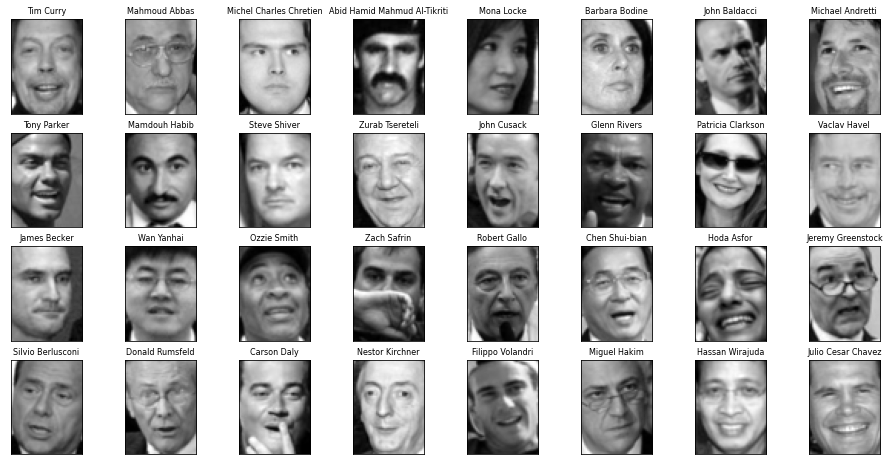

In [5]:
fig = plt.figure(figsize=(16, 8))
for j in range(32):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(images[j,:,:,0],cmap='gray')
    ax.set_title(names[labels[j]],fontdict = {'fontsize': 8})
    plt.xticks([]), plt.yticks([])
plt.show()


### Test images preparation

In [6]:
test_goal = []
for i,j in enumerate(names):
    if np.count_nonzero(labels == i) >80:
        test_goal.append(i)
print(len(test_goal))

5


In [7]:
indeces_of_repeating = []
for i in test_goal:
    ind_rows = np.where(labels==i)[0][:40]
    for j in ind_rows:
        indeces_of_repeating.append(j)
len(indeces_of_repeating), len(set(indeces_of_repeating))

(200, 200)

In [8]:
test_ds = images[indeces_of_repeating,...]
test_labels = labels[indeces_of_repeating]
images = np.delete(images,indeces_of_repeating ,axis = 0)
labels = np.delete(labels, indeces_of_repeating)
images.shape, labels.shape, test_ds.shape,test_labels.shape

((13033, 62, 47, 1), (13033,), (200, 62, 47, 1), (200,))

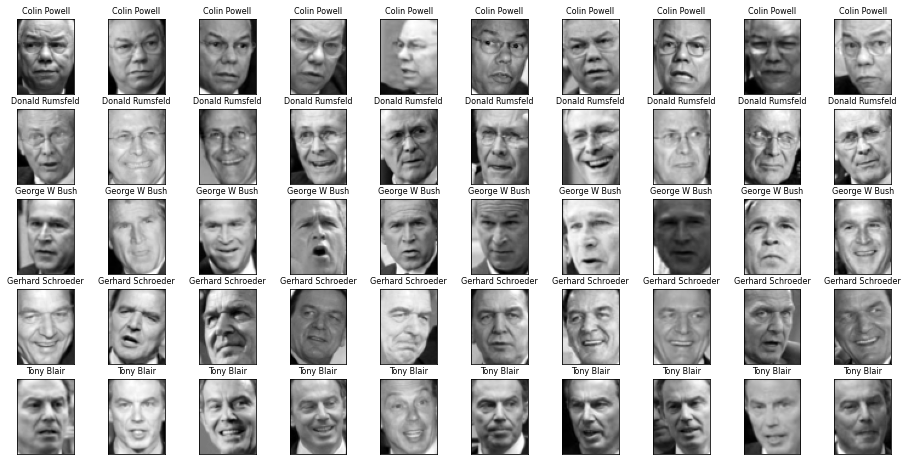

In [9]:
fig = plt.figure(figsize=(16, 8))
for j in range(50):
    ax = fig.add_subplot(5, 10, j+1)
    ax.imshow(test_ds[j*4,:,:,0],cmap='gray')
    ax.set_title(names[test_labels[j*4]],fontdict = {'fontsize': 8})
    plt.xticks([]), plt.yticks([])
plt.show()

### Dataset prefunction 

In [10]:
EMB_SIZE = 128
BATCH_SIZE = 128
NUM_EPOCHS = 50
IM_SIZE = (62, 47, 1)



### Network preparation

In [11]:
import sys
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.utils import to_categorical

Using TensorFlow backend.


In [12]:
def define_model(emg, shape):
    model = tf.keras.models.Sequential([
                                        
    tf.keras.layers.Conv2D(16, (3, 3), padding='same',kernel_initializer='he_uniform', activation='relu'),
    tf.keras.layers.Conv2D(16, (3, 3), padding='same',kernel_initializer='he_uniform', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(32, (3, 3), padding='same',kernel_initializer='he_uniform', activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same',kernel_initializer='he_uniform', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same',kernel_initializer='he_uniform', activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same',kernel_initializer='he_uniform', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same',kernel_initializer='he_uniform', activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same',kernel_initializer='he_uniform', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(256, (3, 3), padding='same',kernel_initializer='he_uniform', activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same',kernel_initializer='he_uniform', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Dropout(0.2),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(emg*2, activation='relu',kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(emg, activation=None,kernel_initializer='he_uniform'),])





    return model

model = define_model(EMB_SIZE, IM_SIZE)

### Contrastive Loss


In [13]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

### Training model 

In [14]:
%%time
optimizer = tf.keras.optimizers.Adam(0.001)
for epoch in range(10):
    print('epoch', epoch)
    mean_loss = []

    train_ds = tf.data.Dataset.from_tensor_slices((images, labels))
    train_ds = train_ds.shuffle(buffer_size=images.shape[0])
    train_ds = train_ds.repeat(NUM_EPOCHS)
    train_ds = train_ds.batch(BATCH_SIZE,drop_remainder=True )
    
    for iteration, (img, label) in enumerate(train_ds):
    
        # Forward
        with tf.GradientTape() as tape:
            embs = model(img)
            loss_value = contastive_loss(embs, label)
            mean_loss.append(loss_value)
        
        # Backward
        grads = tape.gradient(loss_value, model.variables)
        optimizer.apply_gradients(zip(grads, model.variables))

    print('Average loss per epoch:',np.mean(mean_loss))

    

epoch 0
Average loss per epoch: 17.449606
epoch 1
Average loss per epoch: 3.3447623
epoch 2
Average loss per epoch: 1.4731773
epoch 3
Average loss per epoch: 1.2743137
epoch 4
Average loss per epoch: 3.9066267
epoch 5
Average loss per epoch: 0.9499903
epoch 6
Average loss per epoch: 0.8622901
epoch 7
Average loss per epoch: 0.80647564
epoch 8
Average loss per epoch: 0.8489099
epoch 9
Average loss per epoch: 0.9504375
CPU times: user 29min 31s, sys: 1min 13s, total: 30min 44s
Wall time: 48min 25s


### Getting Embedings 

In [15]:
test_embs = model(test_ds)

In [16]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(10, 10))
    for class_idx in range(np.max(targets)+1):
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1])
    plt.legend(labels, loc='best')
    plt.grid(True)

In [17]:
from sklearn.manifold import TSNE

In [18]:
test_x_flat = test_ds.reshape(-1, 62*47)
test_x_2D = TSNE(n_components=2).fit_transform(test_x_flat)


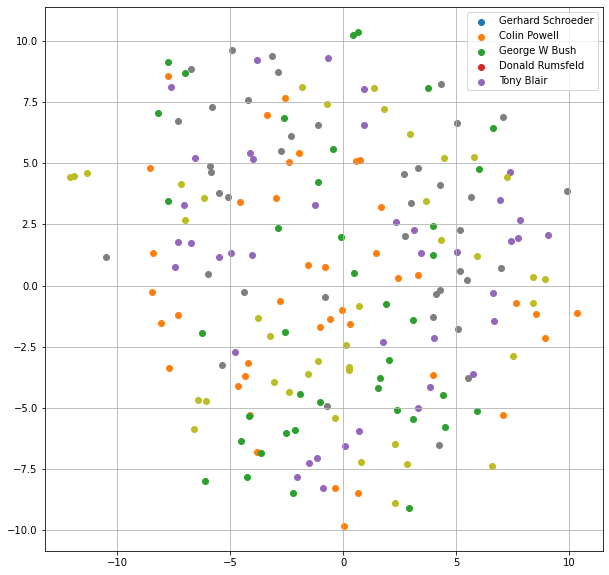

In [19]:
draw_embeddings(test_x_2D, test_labels, set(names[test_labels]))

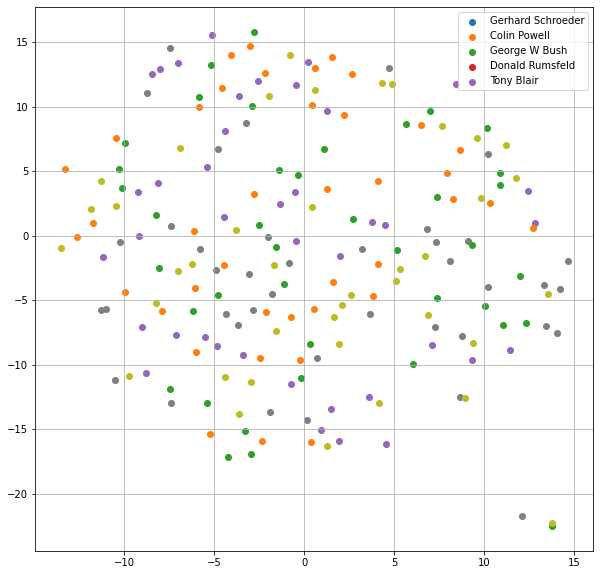

In [20]:
test_embs_2D = TSNE(n_components=2).fit_transform(test_embs)
draw_embeddings(test_embs_2D, test_labels, set(names[test_labels]))

### Distance calculation